In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
##############################
# (A) Logging
##############################
current_log_file = None
def log_print(msg):
    print(msg)

In [3]:
##############################
# (B) Clause & Dataset
##############################

def create_mixed_clause_pool_random_disjoint(global_input_dim, pool_size, features_per_and, seed=None):
    """
    Create a k-AND disjoint formula with specified parameters.

    For example, the formula

    f(x) = (x_i1 ^ x_j1) + (x_i2 ^ x_j2) + ... (x_ik ^ jk)

    has

    n = global_input_dim
    k = pool_size
    2 = features_per_and

    Parameters:
    ----------
    global_input_dim : int
        number of variables x_1, ..., x_n
    pool_size : int
        number of clauses in formula
    features_per_and : int
        2 or 4
    seed : int
        random seed

    Returns:
    -------
    list of list of ints
        Output clauses, eg. {(x_1, x_2, False), (x_3, x_4, False), ...}.
        The False refers to the negative case. If True, the variable is negated in the clause.

    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    max_disjoint = global_input_dim // features_per_and
    disjoint_count = min(max_disjoint, pool_size)
    free_vars = list(range(global_input_dim))
    random.shuffle(free_vars)
    clauses = []
    used=0
    for _ in range(disjoint_count):
        if used+features_per_and> len(free_vars):
            break
        chosen= free_vars[used : used+features_per_and]
        used+= features_per_and
        c= [(v,False) for v in sorted(chosen)]
        clauses.append(c)

    remain= pool_size - len(clauses)
    for _ in range(remain):
        chosen= random.sample(range(global_input_dim), features_per_and)
        c= [(v,False) for v in sorted(chosen)]
        clauses.append(c)

    return clauses

In [4]:
def create_hidden_function_from_clauses(clauses, input_dim):
    """
    Parameters:
    ----------
    clauses : list of list of ints
        List of formula's clauses, eg. {(x_1, x_2, False), (x_3, x_4, False), ...}.
    input_dim : int
        number of variables x_1, ..., x_n

    Returns:
    -------
    function
        Evaluator of f on input x.
    """
    def hidden_func(x):
        res= torch.zeros(x.shape[0], dtype=torch.bool)
        for clause in clauses:
            lits=[]
            for (v,neg) in clause:
                want_1= 1 if not neg else 0
                check= (x[:,v]== want_1)
                lits.append(check)
            conj= torch.stack(lits, dim=1).all(dim=1)
            res|= conj
        return res.float()
    return hidden_func

In [5]:
def generate_range_dataset(
    f_func,
    input_dim,
    num_samples,
    clauses,
    min_true_vars,
    max_true_vars,
    reverse_negated=True
):
    """
    Generate a dataset of inputs and outputs based on logical clauses.

    This uses a “complex negative sampling” approach:
        - For label=1: Pick a random clause, set those bits, and add random bits.
        - For label=0: Forcibly break a random clause and ensure no clause is satisfied.

    Parameters
    ----------
    f_func : callable
        A function that evaluates the formula and returns a label (0 or 1).
    input_dim : int
        The number of input features (i.e., number of variables x_1, ..., x_n).
    num_samples : int
        Number of (X, y) samples to generate.
    clauses : list
        List of clauses, where each clause is a list of (index, negated) pairs.
    min_true_vars : int
        Minimum number of variables set to 1 in each data point.
    max_true_vars : int
        Maximum number of variables set to 1 in each data point.
    reverse_negated : bool, optional
        If True, reset unused variables to 0 after assignment (default: True).

    Returns
    -------
    X : torch.Tensor
        Input tensor of shape [num_samples, input_dim].
    y : torch.Tensor
        Output tensor of shape [num_samples].
    None, None, None :
        Placeholder returns for backward compatibility. ?
    """
    X = torch.zeros(num_samples, input_dim)
    y = torch.zeros(num_samples)

    for i in range(num_samples):
        label = random.choice([0, 1])
        n = random.randint(min_true_vars, max_true_vars)

        if label == 1:
            if not clauses:
                continue

            c_sel = random.choice(clauses)
            for feat, neg in c_sel:
                X[i, feat] = 1.0 if not neg else 0.0

            used = len(c_sel)
            needed = n - used
            if needed < 0:
                continue

            c_feats = {cc[0] for cc in c_sel}
            remain = list(set(range(input_dim)) - c_feats)

            if reverse_negated:
                for rr in remain:
                    X[i, rr] = 0.0

            if needed <= len(remain):
                add_ = random.sample(remain, needed)
                for aa in add_:
                    X[i, aa] = 1.0

        else:
            attempts = 0
            made_neg = False

            while attempts < 100 and not made_neg:
                c_ = random.choice(clauses)
                row_ = np.zeros(input_dim, dtype=np.float32)

                for feat, neg in c_:
                    row_[feat] = 1.0 if not neg else 0.0

                # Flip one literal to break the clause
                f_idx, fneg = random.choice(c_)
                row_[f_idx] = 0.0 if not fneg else 1.0

                used = len(c_)
                c_feats = {c2[0] for c2 in c_}
                cur_ones = int(row_.sum())
                needed = n - cur_ones

                if needed < 0:
                    attempts += 1
                    continue

                remain = list(set(range(input_dim)) - c_feats)

                if reverse_negated:
                    for rr in remain:
                        row_[rr] = 0.0

                if needed > len(remain):
                    attempts += 1
                    continue

                add_ = random.sample(remain, needed)
                for aa in add_:
                    row_[aa] = 1.0

                # Ensure no clause is satisfied
                satisfied = False
                for ccl in clauses:
                    want_all = True
                    for vid, nn in ccl:
                        val_needed = 1.0 if not nn else 0.0
                        if row_[vid] != val_needed:
                            want_all = False
                            break
                    if want_all:
                        satisfied = True
                        break

                if not satisfied:
                    X[i] = torch.from_numpy(row_)
                    made_neg = True

                attempts += 1

        y[i] = f_func(X[i].unsqueeze(0))

    return X, y, None, None, None

In [6]:
##############################
# (C) Model
##############################

"""
f(x) = ReLU(W1@x + b1) * w2 + b2
"""
class ComplexModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1= nn.Linear(input_dim, hidden_dim)
        self.relu= nn.ReLU()
        self.fc2= nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x= self.relu(self.fc1(x))
        return self.fc2(x)

In [7]:
##############################
# (D) aggregator usage + train/test error
##############################
def measure_aggregator_usage(model, clauses):
    """
    Returns (3P1N_pos, 3P1N_neg, 4P_pos, 4P_neg, 3N1P_pos, 3N1P_neg, 2P2N_pos, 2P2N_neg)
    exactly as in the old code – the #neurons that have pos_count=3,4,1,2 among the 4 features
    with w2>0 or w2<0.
    """
    fc1_w= model.fc1.weight.detach().cpu().numpy()
    fc2_w= model.fc2.weight.detach().cpu().numpy()[0]
    c_3p1n_pos=c_3p1n_neg= 0
    c_4p_pos=c_4p_neg=     0
    c_3n1p_pos=c_3n1p_neg= 0
    c_2p2n_pos=c_2p2n_neg= 0
    for clause in clauses:
        sel_idx= [v for (v,neg) in clause]
        for neuron in range(fc1_w.shape[0]):
            w_sub= fc1_w[neuron, sel_idx]
            pos_count= np.sum(w_sub>0)
            w2_val= fc2_w[neuron]
            if pos_count==4:
                if w2_val>0: c_4p_pos+=1
                else:        c_4p_neg+=1
            elif pos_count==3:
                if w2_val>0: c_3p1n_pos+=1
                else:        c_3p1n_neg+=1
            elif pos_count==2:
                if w2_val>0: c_2p2n_pos+=1
                else:        c_2p2n_neg+=1
            elif pos_count==1:
                # That means 3N1P => 3 negative, 1 positive
                if w2_val>0: c_3n1p_pos+=1
                else:        c_3n1p_neg+=1
    return (
        c_3p1n_pos, c_3p1n_neg,
        c_4p_pos,   c_4p_neg,
        c_3n1p_pos, c_3n1p_neg,
        c_2p2n_pos, c_2p2n_neg
    )

def measure_train_test_error(model, loader_train, loader_test):
    criterion= nn.BCEWithLogitsLoss()
    model.eval()
    tot=0.0
    cc=0
    with torch.no_grad():
        for bx,by in loader_train:
            out= model(bx).squeeze()
            loss= criterion(out, by)
            tot+= loss.item()
            cc+=1
    train_err= tot/cc if cc>0 else 0.0

    wrong=0
    total=0
    with torch.no_grad():
        for bx,by in loader_test:
            out= model(bx).squeeze()
            preds= (out>0).float()
            diffs= (preds!= by).float()
            wrong+= diffs.sum().item()
            total+= bx.shape[0]
    test_err= (wrong/ total) if total>0 else 0.0
    if test_err<=0:
        test_err= 1e-9
    return (train_err, test_err)

In [8]:
##############################
# (D2) measure sets of 4P pos or 4P neg for each clause, for overlap stats
##############################

"""
Return for each clause, the indices of rows with all positive W_1 values for each corresonding variable

Return:
pos_sets = [
    [i st clause 1 has w1=++++, w2=+],
    [i st clause 2 has w1=++++, w2=+],
    ...
]
"""
def measure_4p_sets(model, clauses):
    fc1_w= model.fc1.weight.detach().cpu().numpy()    # shape => [hidden_dim,32]
    fc2_w= model.fc2.weight.detach().cpu().numpy()[0] # shape => [hidden_dim,]
    hidden_dim= fc1_w.shape[0]

    pos_sets= []
    neg_sets= []
    for i,clause in enumerate(clauses):
        sel_idx= [v for (v,n) in clause]
        pos_neurons= set()
        neg_neurons= set()
        for neuron in range(hidden_dim):
            w_sub= fc1_w[neuron, sel_idx]
            pos_count= np.sum(w_sub>0)
            w2_val= fc2_w[neuron]
            if pos_count==4:
                if w2_val>0:
                    pos_neurons.add(neuron)
                else:
                    neg_neurons.add(neuron)
        pos_sets.append(pos_neurons)
        neg_sets.append(neg_neurons)
    return pos_sets, neg_sets

def measure_4p_overlap_stats(pos_sets, neg_sets, prior_pos_sets=None, prior_neg_sets=None):
    ccount= len(pos_sets)
    total_4p_pos= sum(len(s) for s in pos_sets)
    sum_of_clauseOverlaps_4p_pos=0
    for i in range(ccount):
        for j in range(i+1, ccount):
            sum_of_clauseOverlaps_4p_pos+= len( pos_sets[i].intersection(pos_sets[j]) )

    if prior_pos_sets is not None:
        overlap_4p_pos_with_prior=0
        for i in range(ccount):
            overlap_4p_pos_with_prior+= len(pos_sets[i].intersection(prior_pos_sets[i]))
    else:
        overlap_4p_pos_with_prior= 0

    total_4p_neg= sum(len(s) for s in neg_sets)
    sum_of_clauseOverlaps_4p_neg=0
    for i in range(ccount):
        for j in range(i+1, ccount):
            sum_of_clauseOverlaps_4p_neg+= len( neg_sets[i].intersection(neg_sets[j]) )

    if prior_neg_sets is not None:
        overlap_4p_neg_with_prior=0
        for i in range(ccount):
            overlap_4p_neg_with_prior+= len(neg_sets[i].intersection(prior_neg_sets[i]))
    else:
        overlap_4p_neg_with_prior= 0

    return {
        "total_4p_pos": total_4p_pos,
        "sum_of_clauseOverlaps_4p_pos": sum_of_clauseOverlaps_4p_pos,
        "overlap_4p_pos_with_prior": overlap_4p_pos_with_prior,
        "total_4p_neg": total_4p_neg,
        "sum_of_clauseOverlaps_4p_neg": sum_of_clauseOverlaps_4p_neg,
        "overlap_4p_neg_with_prior": overlap_4p_neg_with_prior
    }

In [9]:
##############################
# Reorder / plot snapshots
##############################
def reorder_cols_by_clause(fc1_w, clauses, max_clauses=8, k=4):
    # print(f"clauses: {clauses}, k: {k}")
    k_clauses= [c_ for c_ in clauses if len(c_)==k]
    # print(f"k_clauses: {k_clauses}")
    k_clauses= k_clauses[:max_clauses]
    used_cols=[]
    used_labels=[]
    for c_ in k_clauses:
        var_idx_list= [v for (v,neg) in c_]
        var_idx_list= sorted(var_idx_list)
        for v_ in var_idx_list:
            used_cols.append(v_)
            used_labels.append(str(v_))
    if len(used_cols)> fc1_w.shape[1]:
        used_cols= used_cols[: fc1_w.shape[1]]
        used_labels= used_labels[: fc1_w.shape[1]]
    W_reordered= fc1_w[:, used_cols]
    return W_reordered, used_labels

def reorder_rows_by_l2pos(W_l1, fc2_w):
    idx= np.arange(W_l1.shape[0])
    pos_idx= np.array([i for i in idx if fc2_w[i]>0])
    neg_idx= np.array([i for i in idx if fc2_w[i]<=0])
    if len(pos_idx)>0:
        sorted_pos= pos_idx[np.argsort(fc2_w[pos_idx])[::-1]]
    else:
        sorted_pos= np.array([], dtype=int)
    if len(neg_idx)>0:
        sorted_neg= neg_idx[np.argsort(fc2_w[neg_idx])[::-1]]
    else:
        sorted_neg= np.array([], dtype=int)
    new_order= np.concatenate((sorted_pos, sorted_neg), axis=0)
    W_rows= W_l1[new_order,:]
    w2_new= fc2_w[new_order]
    # print("W_rows", W_rows)
    return W_rows, w2_new, new_order

def plot_single_snapshot(fc1_w, fc2_w, step_label, clauses, model_name, out_dir="."):
    import matplotlib.gridspec as gridspec
    import matplotlib.pyplot as plt

    W_cols, xlabels= reorder_cols_by_clause(fc1_w, clauses, max_clauses=8)
    W_rows, w2_rows, _= reorder_rows_by_l2pos(W_cols, fc2_w)
    pos_count= sum(w2_rows>0)

    fig= plt.figure(figsize=(8,4))
    fig.suptitle(f"{model_name}, step={step_label}", fontsize=14, fontweight="bold")
    gs= gridspec.GridSpec(1,2, width_ratios=[3,0.5], wspace=0.05)

    ax_l1= fig.add_subplot(gs[0,0])
    cmax= abs(W_rows).max()
    im1= ax_l1.imshow(W_rows, cmap="bwr_r", aspect="auto", origin="upper", vmin=-cmax, vmax=cmax)
    ax_l1.set_yticks([])
    ax_l1.axhline(y= pos_count-0.5, color='k', linestyle='--')
    ax_l1.set_xticks(np.arange(len(xlabels)))
    ax_l1.set_xticklabels(xlabels, rotation=45, fontsize=8)
    ax_l1.set_title("Layer1", fontsize=10, fontweight="bold")

    ax_l2= fig.add_subplot(gs[0,1])
    w2_resh= w2_rows.reshape(-1,1)
    c2max= abs(w2_resh).max()
    im2= ax_l2.imshow(w2_resh, cmap="bwr_r", aspect="auto", origin="upper", vmin=-c2max, vmax=c2max)
    ax_l2.set_yticks([])
    ax_l2.set_xticks([])
    ax_l2.axhline(y= pos_count-0.5, color='k', linestyle='--')
    ax_l2.set_title("Layer2", fontsize=10, fontweight="bold")

    plt.tight_layout(rect=[0,0,1,0.92])
    plt.show()

    outfname= os.path.join(out_dir, f"snap_{model_name}_step_{step_label.replace('/','_')}.pdf")
    fig.savefig(outfname, dpi=120)
    plt.close(fig)
    print(f"Saved => {outfname}\n")

In [10]:
##############################
# We'll store the 6 special snapshots => [0/5,3/5,6/5,10/5,15/5,100/5]
##############################
snapshots_by_run={}
def store_snapshot_for_run(run_i, label_str, fc1_arr, fc2_arr, b1_arr, b2_arr):
    global snapshots_by_run
    snapshots_by_run[(run_i,label_str)]= (fc1_arr.copy(), fc2_arr.copy(), b1_arr.copy(), b2_arr.copy())

def plot_6final_snapshots_2x3_for_run(run_i, run_name, clauses, out_dir=".", k=4):
    import matplotlib.gridspec as gridspec
    import matplotlib.pyplot as plt

    final_keys= ["0/5","100/5","150/5","200/5","300/5","400/5"]
    fig= plt.figure(figsize=(24,10))  # bigger subplots
    fig.suptitle(f"{run_name} => final 2×3 snapshots", fontsize=18, fontweight="bold")
    outer_gs= gridspec.GridSpec(2,3, wspace=0.5, hspace=0.2)

    idx=0
    for r_ in range(2):
        for c_ in range(3):
            if idx>= len(final_keys):
                break
            step_label= final_keys[idx]
            idx+=1
            key_ = (run_i, step_label)
            if key_ not in snapshots_by_run:
                print(f"WARNING => snapshot not found => run={run_i}, step={step_label}")
                continue

            # print(f"k={k}")
            (fc1_w, fc2_w, b1_w, b2_w)= snapshots_by_run[key_]
            # print(f"fc1_w, fc2_w: {fc1_w.shape}, {fc2_w.shape}")

            W_cols, xlabels= reorder_cols_by_clause(fc1_w, clauses, k=k)
            # print("W_cols", W_cols)
            W_rows, w2_rows, _= reorder_rows_by_l2pos(W_cols, fc2_w)
            b1_rows = b1_w[np.argsort(-w2_rows)]  # Reorder b1_w using same ordering as rows
            pos_count= sum(w2_rows>0)

            in_gs= gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios=[3, 0.3, 0.5], subplot_spec=outer_gs[r_,c_], wspace=0.05)
            ax_l1= fig.add_subplot(in_gs[0,0])
            cmax= abs(W_rows).max()
            im1= ax_l1.imshow(W_rows, cmap="bwr_r", aspect="auto", origin="upper", vmin=-cmax, vmax=cmax)
            # Add text annotations for Layer1
            for i in range(W_rows.shape[0]):
                for j in range(W_rows.shape[1]):
                    text = ax_l1.text(j, i, f'{W_rows[i,j]:.1f}',
                                   ha="center", va="center", color="black", fontsize=6)
            ax_l1.set_title(f"Step={step_label}\nLayer1", fontsize=12, fontweight="bold")
            ax_l1.set_yticks([])
            ax_l1.axhline(y= pos_count-0.5, color='k', linestyle='--')
            ax_l1.set_xticks(np.arange(len(xlabels)))
            ax_l1.set_xticklabels(xlabels, rotation=45, fontsize=9)

            # Add b1_w plot
            ax_b1 = fig.add_subplot(in_gs[0,1])
            b1_resh = b1_rows.reshape(-1,1)
            b1max = abs(b1_resh).max()
            im_b1 = ax_b1.imshow(b1_resh, cmap="bwr_r", aspect="auto", origin="upper", vmin=-b1max, vmax=b1max)
            # Add text annotations for Bias1
            for i in range(b1_resh.shape[0]):
                text = ax_b1.text(0, i, f'{b1_resh[i,0]:.1f}',
                               ha="center", va="center", color="black", fontsize=6)
            ax_b1.set_title("Bias1", fontsize=10, fontweight="bold")
            ax_b1.set_yticks([])
            ax_b1.set_xticks([])
            ax_b1.axhline(y= pos_count-0.5, color='k', linestyle='--')

            ax_l2= fig.add_subplot(in_gs[0,2])
            w2_resh= w2_rows.reshape(-1,1)
            c2max= abs(w2_resh).max()
            im2= ax_l2.imshow(w2_resh, cmap="bwr_r", aspect="auto", origin="upper", vmin=-c2max, vmax=c2max)
            # Add text annotations for Layer2
            for i in range(w2_resh.shape[0]):
                text = ax_l2.text(0, i, f'{w2_resh[i,0]:.1f}',
                               ha="center", va="center", color="black", fontsize=6)
            ax_l2.set_title("Layer2", fontsize=10, fontweight="bold")
            ax_l2.set_yticks([])
            ax_l2.set_xticks([])
            ax_l2.axhline(y= pos_count-0.5, color='k', linestyle='--')

    fig.tight_layout(rect=[0,0,1,0.93])
    outpdf= os.path.join(out_dir, f"{run_name}_final_6snap_2x3.pdf")
    plt.savefig(outpdf, dpi=120)
    plt.show()
    plt.close(fig)
    print(f"Saved => {outpdf}")

In [11]:
def run_single_model(
    run_i,
    j_size=32,
    num_features_per_clause=4,
    train_size=10000,
    test_size=2000,
    min_true_vars=4,
    max_true_vars=8,
    seed_offset=0,
    base_dir=".",
    run_name="RunX",
    l2_reg_factor=1e-5,
    l1_reg_factor=0.0
):
    """
    Trains and evaluates a model using a randomly chosen 4-clause logical formula.

    This function runs a single experiment where:
      - A formula is randomly chosen from a global clause pool.
      - A model is trained to learn that formula on synthetic data.
      - Various intermediate metrics are collected and visualized.

    The function tracks how well the model learns and generalizes using
    specific clause-pattern statistics (e.g., 3P1N, 4P, etc.) at partial
    training steps and plots the trends over time.

    Parameters
    ----------
    run_i : int
        Index of the current run (used for seeding and naming).
    j_size : int, optional
        Hidden layer size of the model (default is 32).
    train_size : int, optional
        Number of training samples to generate (default is 10,000).
    test_size : int, optional
        Number of test samples to generate (default is 2,000).
    min_true_vars : int, optional
        Minimum number of active variables (set to 1) in each sample.
    max_true_vars : int, optional
        Maximum number of active variables (set to 1) in each sample.
    seed_offset : int, optional
        Value added to seed for randomness control (default is 0).
    base_dir : str, optional
        Base directory for storing outputs like plots (default is current directory).
    run_name : str, optional
        Identifier for the current run (used in logs).
    l2_reg_factor : float, optional
        L2 regularization weight (default is 1e-5).
    l1_reg_factor : float, optional
        L1 regularization weight (default is 0.0).

    Returns
    -------
    aggregator_run : np.ndarray
        Array of shape (20, 16) storing intermediate and final aggregator statistics
        such as clause pattern counts, errors, and overlap metrics.
    """

    global global_big_pool
    if global_big_pool is None:
        print("ERROR => define global_big_pool in main.")
        return

    local_seed= 57 + seed_offset + 1000*run_i
    random.seed(local_seed)
    np.random.seed(local_seed)
    torch.manual_seed(local_seed)

    # pick 4 random clauses from big_pool
    cset= random.sample(global_big_pool, 4)
    log_print(f"{run_name}: using new random 4-AND formula => {cset}")

    # dataset
    f_func= create_hidden_function_from_clauses(cset,32)
    X_train,y_train,_,_,_= generate_range_dataset(f_func,32,train_size,cset,min_true_vars,max_true_vars)
    X_test,y_test,_,_,_= generate_range_dataset(f_func,32,test_size,cset,min_true_vars,max_true_vars)

    perm= torch.randperm(X_train.shape[0])
    X_train= X_train[perm]
    y_train= y_train[perm]
    perm_t= torch.randperm(X_test.shape[0])
    X_test= X_test[perm_t]
    y_test= y_test[perm_t]

    I_= torch.eye(32)
    X_train_t= torch.mm(X_train,I_.t())
    X_test_t= torch.mm(X_test,I_.t())
    train_data= TensorDataset(X_train_t,y_train)
    test_data= TensorDataset(X_test_t,y_test)
    train_loader= DataLoader(train_data,batch_size=64,shuffle=True)
    test_loader= DataLoader(test_data,batch_size=64,shuffle=False)

    aggregator_labels= [f"{i}/5" for i in range(16)] + ["25/5","50/5","75/5","100/5", "125/5", "150/5", "175/5", "200/5", "300/5", "400/5"]
    aggregator_thisrun= np.zeros((26,16), dtype=np.float32)

    model= ComplexModel(32,j_size)
    criterion= nn.BCEWithLogitsLoss()
    optimizer= torch.optim.Adam(model.parameters(), lr=1e-3)
    train_batches= list(train_loader)
    B= len(train_batches)
    chunk= max(1, B//5)

    prior_pos_sets= None
    prior_neg_sets= None

    def measure_store(label_str, step_index):
        # *** Move nonlocal to top of function *** to fix SyntaxError
        nonlocal prior_pos_sets, prior_neg_sets

        usage_= measure_aggregator_usage(model, cset)
        (c3p1n_p,c3p1n_n,
         c4p_p,c4p_n,
         c3n1p_p,c3n1p_n,
         c2p2n_p,c2p2n_n)= usage_
        aggregator_thisrun[step_index,0]= c3p1n_p
        aggregator_thisrun[step_index,1]= c3p1n_n
        aggregator_thisrun[step_index,2]= c4p_p
        aggregator_thisrun[step_index,3]= c4p_n
        aggregator_thisrun[step_index,4]= c3n1p_p
        aggregator_thisrun[step_index,5]= c3n1p_n
        aggregator_thisrun[step_index,6]= c2p2n_p
        aggregator_thisrun[step_index,7]= c2p2n_n

        tr_e,ts_e= measure_train_test_error(model, train_loader, test_loader)
        aggregator_thisrun[step_index,8]= tr_e
        aggregator_thisrun[step_index,9]= ts_e

        pos_sets, neg_sets= measure_4p_sets(model, cset)
        over_ = measure_4p_overlap_stats(pos_sets, neg_sets, prior_pos_sets, prior_neg_sets)

        aggregator_thisrun[step_index,10]= over_["total_4p_pos"]
        aggregator_thisrun[step_index,11]= over_["overlap_4p_pos_with_prior"]
        aggregator_thisrun[step_index,12]= over_["sum_of_clauseOverlaps_4p_pos"]
        aggregator_thisrun[step_index,13]= over_["total_4p_neg"]
        aggregator_thisrun[step_index,14]= over_["overlap_4p_neg_with_prior"]
        aggregator_thisrun[step_index,15]= over_["sum_of_clauseOverlaps_4p_neg"]

        prior_pos_sets= pos_sets
        prior_neg_sets= neg_sets

        log_print(f"{run_name}: step={label_str}, trainErr={tr_e:.4f}, testErr={ts_e:.4f}, "
                  f"4P+={c4p_p:.2f},4P-={c4p_n:.2f}, total_4p_pos={over_['total_4p_pos']}, "
                  f"overlap_4p_pos_with_prior={over_['overlap_4p_pos_with_prior']}, "
                  f"sum_of_clauseOverlaps_4p_pos={over_['sum_of_clauseOverlaps_4p_pos']}")

        label_int = int(label_str.split("/")[0])
        if label_str in ["0/5","3/5","6/5","10/5","15/5","100/5", "125/5", "150/5", "175/5", "200/5", "300/5", "400/5"]:
            fc1_w= model.fc1.weight.detach().cpu().numpy()
            fc2_w= model.fc2.weight.detach().cpu().numpy()[0]
            b1_w= model.fc1.bias.detach().cpu().numpy()
            b2_w= model.fc2.bias.detach().cpu().numpy()[0]
            store_snapshot_for_run(run_i, label_str, fc1_w, fc2_w, b1_w, b2_w)

    def do_train_chunk(n_):
        for _ in range(n_):
            bx,by= next(iter(train_loader))
            optimizer.zero_grad()
            out= model(bx).squeeze()
            loss= criterion(out,by)
            if l2_reg_factor>0:
                sum_l2=0.0
                for param in model.parameters():
                    sum_l2+= torch.sum(param**2)
                loss+= (l2_reg_factor* sum_l2)
            if l1_reg_factor>0:
                sum_l1=0.0
                for param in model.parameters():
                    sum_l1+= torch.sum(torch.abs(param))
                loss+= (l1_reg_factor* sum_l1)
            loss.backward()
            optimizer.step()

    # partial steps => i=0..15 => plus 25,50,75,100
    step_idx=0
    measure_store("0/5", step_idx)
    step_idx+=1

    for e_ in range(1,4):
        i_start= (e_-1)*5+1
        i_stop= e_*5
        for i_ in range(i_start, i_stop+1):
            do_train_chunk(chunk)
            measure_store(f"{i_}/5", step_idx)
            step_idx+=1

    leftover= (5-3)*B
    do_train_chunk(leftover)
    measure_store("25/5", step_idx)
    step_idx+=1

    do_train_chunk(5*B)
    measure_store("50/5", step_idx)
    step_idx+=1

    do_train_chunk(5*B)
    measure_store("75/5", step_idx)
    step_idx+=1

    do_train_chunk(5*B)
    measure_store("100/5", step_idx)
    step_idx+=1

    do_train_chunk(5*B)
    measure_store("125/5", step_idx)
    step_idx+=1

    do_train_chunk(5*B)
    measure_store("150/5", step_idx)
    step_idx+=1

    do_train_chunk(5*B)
    measure_store("175/5", step_idx)
    step_idx+=1

    do_train_chunk(5*B)
    measure_store("200/5", step_idx)
    step_idx+=1

    do_train_chunk(20*B)
    measure_store("300/5", step_idx)
    step_idx+=1

    do_train_chunk(20*B)
    measure_store("400/5", step_idx)
    step_idx+=1

    # aggregator lines
    aggregator_run= aggregator_thisrun
    xvals= np.arange(26)
    step_labels= aggregator_labels

    s3p1n_pos= aggregator_run[:,0]
    s3p1n_neg= aggregator_run[:,1]
    s4p_pos=   aggregator_run[:,2]
    s4p_neg=   aggregator_run[:,3]
    s3n1p_pos= aggregator_run[:,4]
    s3n1p_neg= aggregator_run[:,5]
    s2p2n_pos= aggregator_run[:,6]
    s2p2n_neg= aggregator_run[:,7]
    train_e= aggregator_run[:,8]
    test_e=  aggregator_run[:,9]

    total_4p_pos= aggregator_run[:,10]
    overlap_4p_pos_with_prior= aggregator_run[:,11]
    sum_of_clauseOverlaps_4p_pos= aggregator_run[:,12]
    total_4p_neg= aggregator_run[:,13]
    overlap_4p_neg_with_prior= aggregator_run[:,14]
    sum_of_clauseOverlaps_4p_neg= aggregator_run[:,15]

    fig, ax1= plt.subplots(figsize=(10,6))
    ax1.plot(xvals, s3p1n_pos, "-", color="blue", marker="o", linewidth=2, label="3P1N pos")
    ax1.plot(xvals, s3p1n_neg, "-", color="green",marker="o", linewidth=2, label="3P1N neg")
    ax1.plot(xvals, s4p_pos,   "-", color="blue", marker="s", linewidth=2, label="4P pos")
    ax1.plot(xvals, s4p_neg,   "-", color="green",marker="s", linewidth=2, label="4P neg")
    ax1.plot(xvals, s3n1p_pos, "-", color="blue", marker="^", linewidth=2, label="3N1P pos")
    ax1.plot(xvals, s3n1p_neg, "-", color="green",marker="^", linewidth=2, label="3N1P neg")
    ax1.plot(xvals, s2p2n_pos, "-", color="blue", marker="D", linewidth=2, label="2P2N pos")
    ax1.plot(xvals, s2p2n_neg, "-", color="green",marker="D", linewidth=2, label="2P2N neg")

    ax1.set_xlabel("Partial Steps => i/5 up to epoch=3 + 25/5,50/5,75/5,100/5,125/5,150/5,175/5,200/5", fontsize=12, fontweight="bold")
    ax1.set_ylabel("Pattern Count/clause", fontsize=12, fontweight="bold")
    ax1.grid(True)
    ax1.legend(loc='center left', bbox_to_anchor=(1.3,0.5), fontsize=10)
    ax1.set_xticks(xvals)
    ax1.set_xticklabels(step_labels, rotation=45, fontsize=10)

    ax2= ax1.twinx()
    ax2.plot(xvals, train_e, "-", color="red", linewidth=2, label="Train BCE")
    ax2.set_ylabel("Train BCE Error", color="red", fontsize=12, fontweight="bold")
    ax2.tick_params(axis="y", labelcolor="red")

    plt.title(f"Run #{run_i+1} => Distinct Random 4-AND formula", fontsize=14, fontweight="bold")
    plt.tight_layout()

    outdir_pdf= os.path.join(base_dir,"pdfs")
    os.makedirs(outdir_pdf, exist_ok=True)
    outpdf= os.path.join(outdir_pdf, f"run_{run_i+1}_aggregator_lineplot.pdf")
    plt.savefig(outpdf, dpi=120)
    plt.show()
    plt.close(fig)
    log_print(f"Saved aggregator line => {outpdf}")

    # print(f"k={num_features_per_clause}")
    plot_6final_snapshots_2x3_for_run(
        run_i=run_i,
        run_name=f"Random4 Run={run_i+1}",
        clauses=cset,
        out_dir=outdir_pdf,
        k=num_features_per_clause
    )

    return aggregator_run

# Claire Tinkering

In [12]:
seed=57
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
global_big_pool= None

In [13]:
global global_big_pool
global_big_pool= create_mixed_clause_pool_random_disjoint(
    global_input_dim=16,
    pool_size=1000,
    features_per_and=2,
    seed=seed
)

In [14]:
global_big_pool

[[(4, False), (15, False)],
 [(6, False), (11, False)],
 [(10, False), (12, False)],
 [(2, False), (7, False)],
 [(8, False), (14, False)],
 [(0, False), (3, False)],
 [(9, False), (13, False)],
 [(1, False), (5, False)],
 [(6, False), (11, False)],
 [(1, False), (12, False)],
 [(8, False), (15, False)],
 [(8, False), (13, False)],
 [(4, False), (9, False)],
 [(2, False), (4, False)],
 [(8, False), (12, False)],
 [(4, False), (13, False)],
 [(8, False), (13, False)],
 [(5, False), (9, False)],
 [(5, False), (13, False)],
 [(3, False), (7, False)],
 [(6, False), (8, False)],
 [(6, False), (15, False)],
 [(0, False), (14, False)],
 [(7, False), (14, False)],
 [(0, False), (6, False)],
 [(1, False), (9, False)],
 [(7, False), (10, False)],
 [(1, False), (11, False)],
 [(8, False), (14, False)],
 [(0, False), (4, False)],
 [(0, False), (4, False)],
 [(5, False), (11, False)],
 [(10, False), (11, False)],
 [(0, False), (8, False)],
 [(10, False), (15, False)],
 [(2, False), (5, False)],
 [(

Run 4AND k=2: using new random 4-AND formula => [[(3, False), (12, False)], [(7, False), (9, False)], [(13, False), (14, False)], [(0, False), (2, False)]]
Run 4AND k=2: step=0/5, trainErr=0.6961, testErr=0.4820, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=1/5, trainErr=0.6889, testErr=0.4560, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=2/5, trainErr=0.6843, testErr=0.4160, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=3/5, trainErr=0.6801, testErr=0.3980, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=4/5, trainErr=0.6751, testErr=0.3880, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=5/5, trainErr=0.6697, testErr=0.3800, 4P+=0.00,4P-=0.00, total_4p

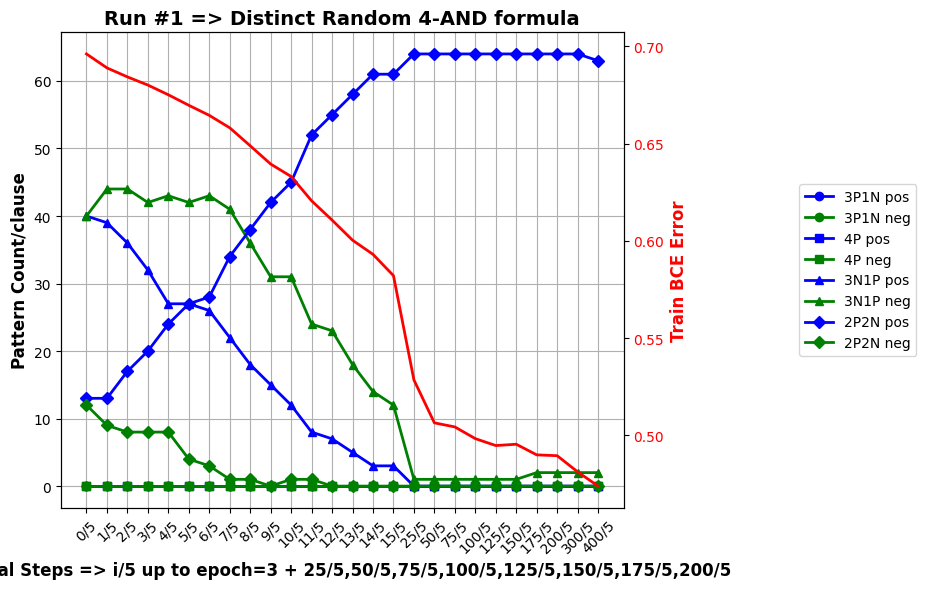

Saved aggregator line => ./pdfs/run_1_aggregator_lineplot.pdf


/tmp/ipykernel_2699750/334786340.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.93])


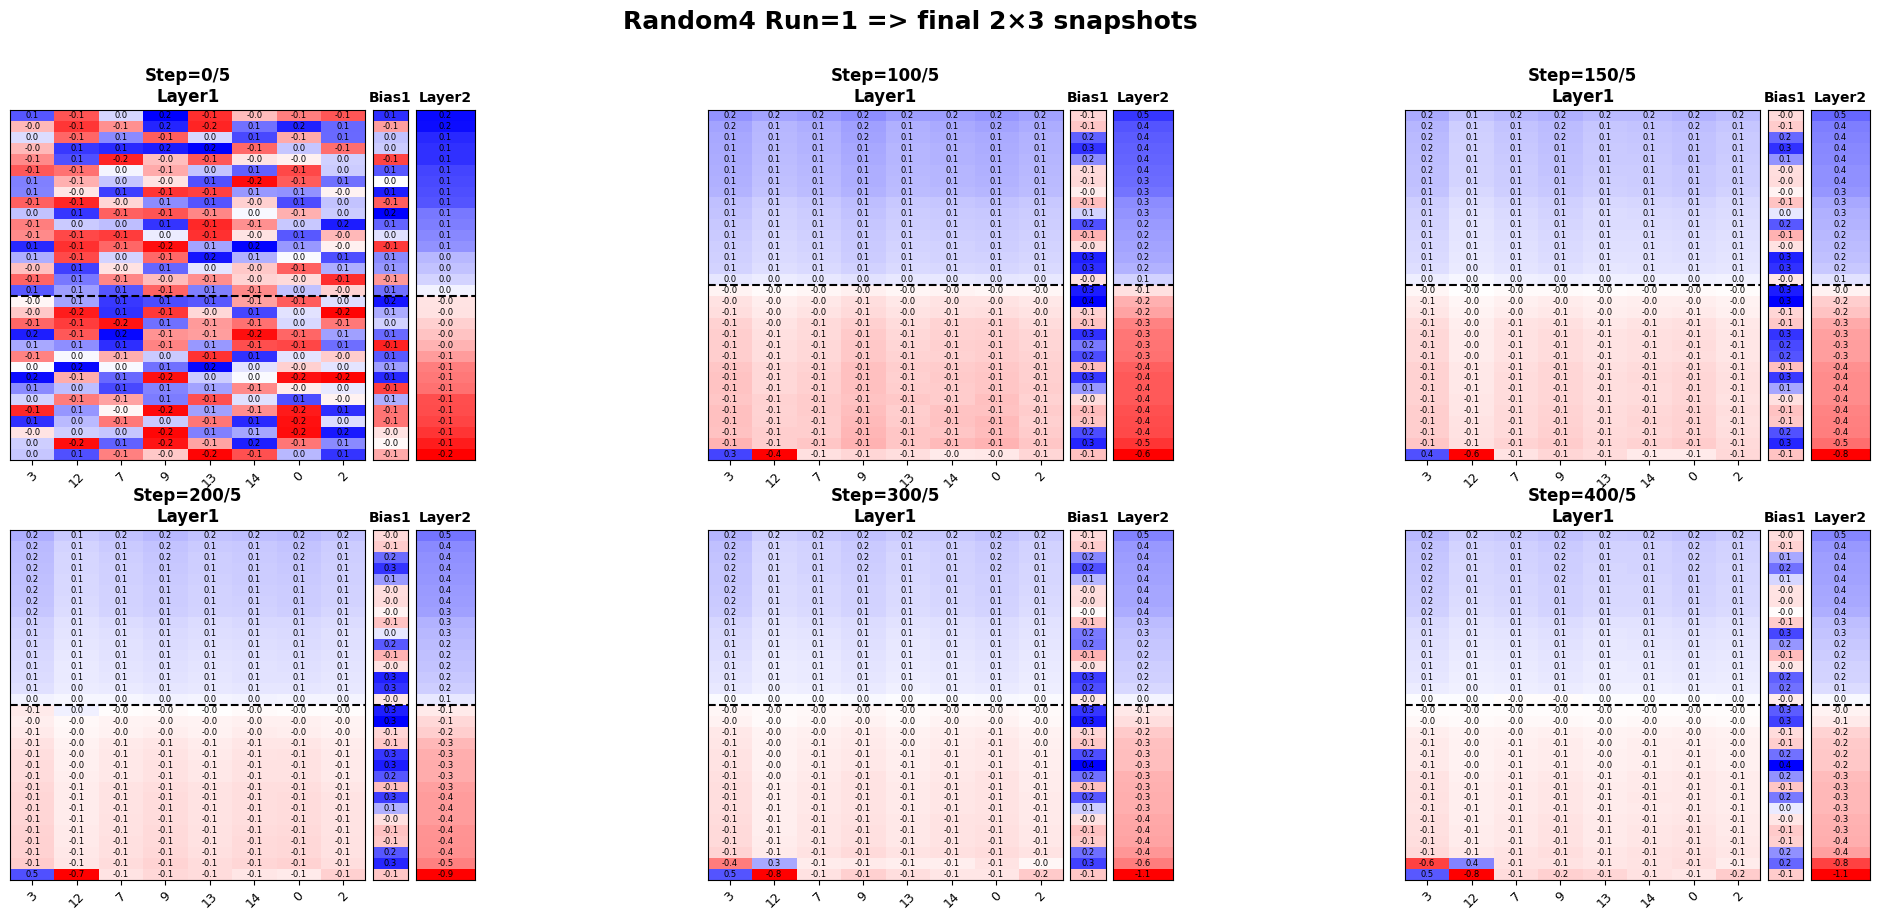

Saved => ./pdfs/Random4 Run=1_final_6snap_2x3.pdf


In [16]:
run = run_single_model(
    run_i= 0,
    num_features_per_clause=2,
    j_size=32,
    train_size=5000,
    test_size=500,
    min_true_vars=0,
    max_true_vars=16,
    seed_offset=0,
    # base_dir=
    run_name= f"Run 4AND k=2",
    l2_reg_factor=1e-2,
    l1_reg_factor=0.0
)

In [ ]:
run = run_single_model(
    run_i= 0,
    num_features_per_clause=2,
    j_size=32,
    train_size=5000,
    test_size=500,
    min_true_vars=0,
    max_true_vars=16,
    seed_offset=0,
    run_name= f"Run 4AND k=2",
    l2_reg_factor=1e-4,
    l1_reg_factor=0.0
)

In [ ]:
run = run_single_model(
    run_i= 0,
    num_features_per_clause=2,
    j_size=24,
    train_size=5000,
    test_size=500,
    min_true_vars=0,
    max_true_vars=16,
    seed_offset=0,
    run_name= f"Run 4AND k=2",
    l2_reg_factor=1e-3,
    l1_reg_factor=0.0
)

In [ ]:
run = run_single_model(
    run_i= 0,
    num_features_per_clause=2,
    j_size=12,
    train_size=5000,
    test_size=500,
    min_true_vars=0,
    max_true_vars=16,
    seed_offset=0,
    # base_dir=
    run_name= f"Run 4AND k=2",
    l2_reg_factor=1e-4,
    l1_reg_factor=0.0
)

In [ ]:
run = run_single_model(
    run_i= 0,
    num_features_per_clause=2,
    j_size=8,
    train_size=5000,
    test_size=1000,
    min_true_vars=2,
    max_true_vars=4,
    seed_offset=0,
    # base_dir=
    run_name= f"Run 4AND k=2",
    l2_reg_factor=1e-5,
    l1_reg_factor=0.0
)

In [ ]:
run = run_single_model(
    run_i= 0,
    num_features_per_clause=2,
    j_size=16,
    train_size=5000,
    test_size=1000,
    min_true_vars=2,
    max_true_vars=5,
    seed_offset=0,
    # base_dir=
    run_name= f"Run 4AND k=2",
    l2_reg_factor=1e-4,
    l1_reg_factor=0.0
)

Run 4AND k=2: using new random 4-AND formula => [[(3, False), (12, False)], [(7, False), (9, False)], [(13, False), (14, False)], [(0, False), (2, False)]]
Run 4AND k=2: step=0/5, trainErr=0.6990, testErr=0.4860, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=1/5, trainErr=0.6945, testErr=0.4860, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=2/5, trainErr=0.6921, testErr=0.4860, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=3/5, trainErr=0.6889, testErr=0.4860, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=4/5, trainErr=0.6868, testErr=0.4850, 4P+=0.00,4P-=0.00, total_4p_pos=0, overlap_4p_pos_with_prior=0, sum_of_clauseOverlaps_4p_pos=0
Run 4AND k=2: step=5/5, trainErr=0.6842, testErr=0.4840, 4P+=0.00,4P-=0.00, total_4p

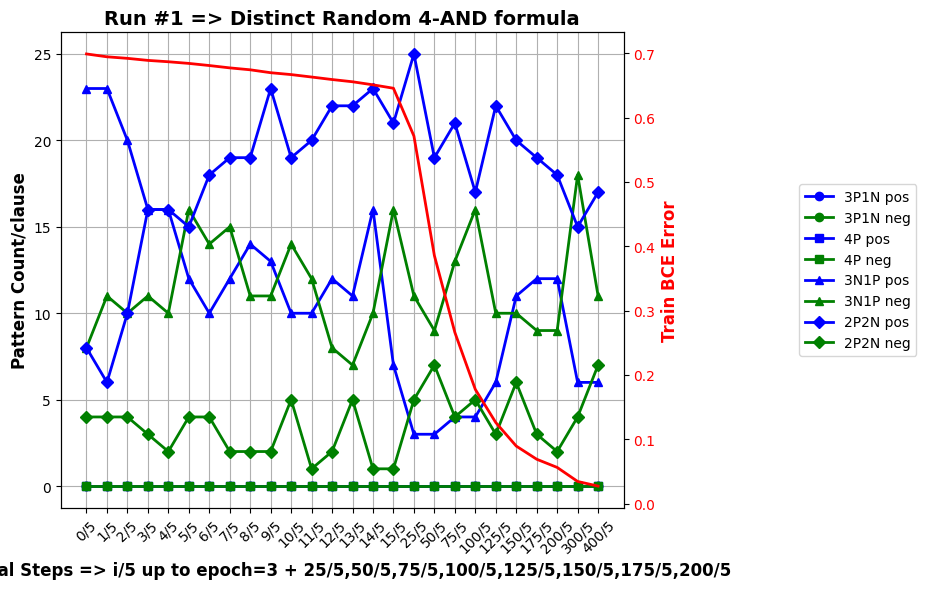

Saved aggregator line => ./pdfs/run_1_aggregator_lineplot.pdf


/tmp/ipykernel_2699750/334786340.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0,0,1,0.93])


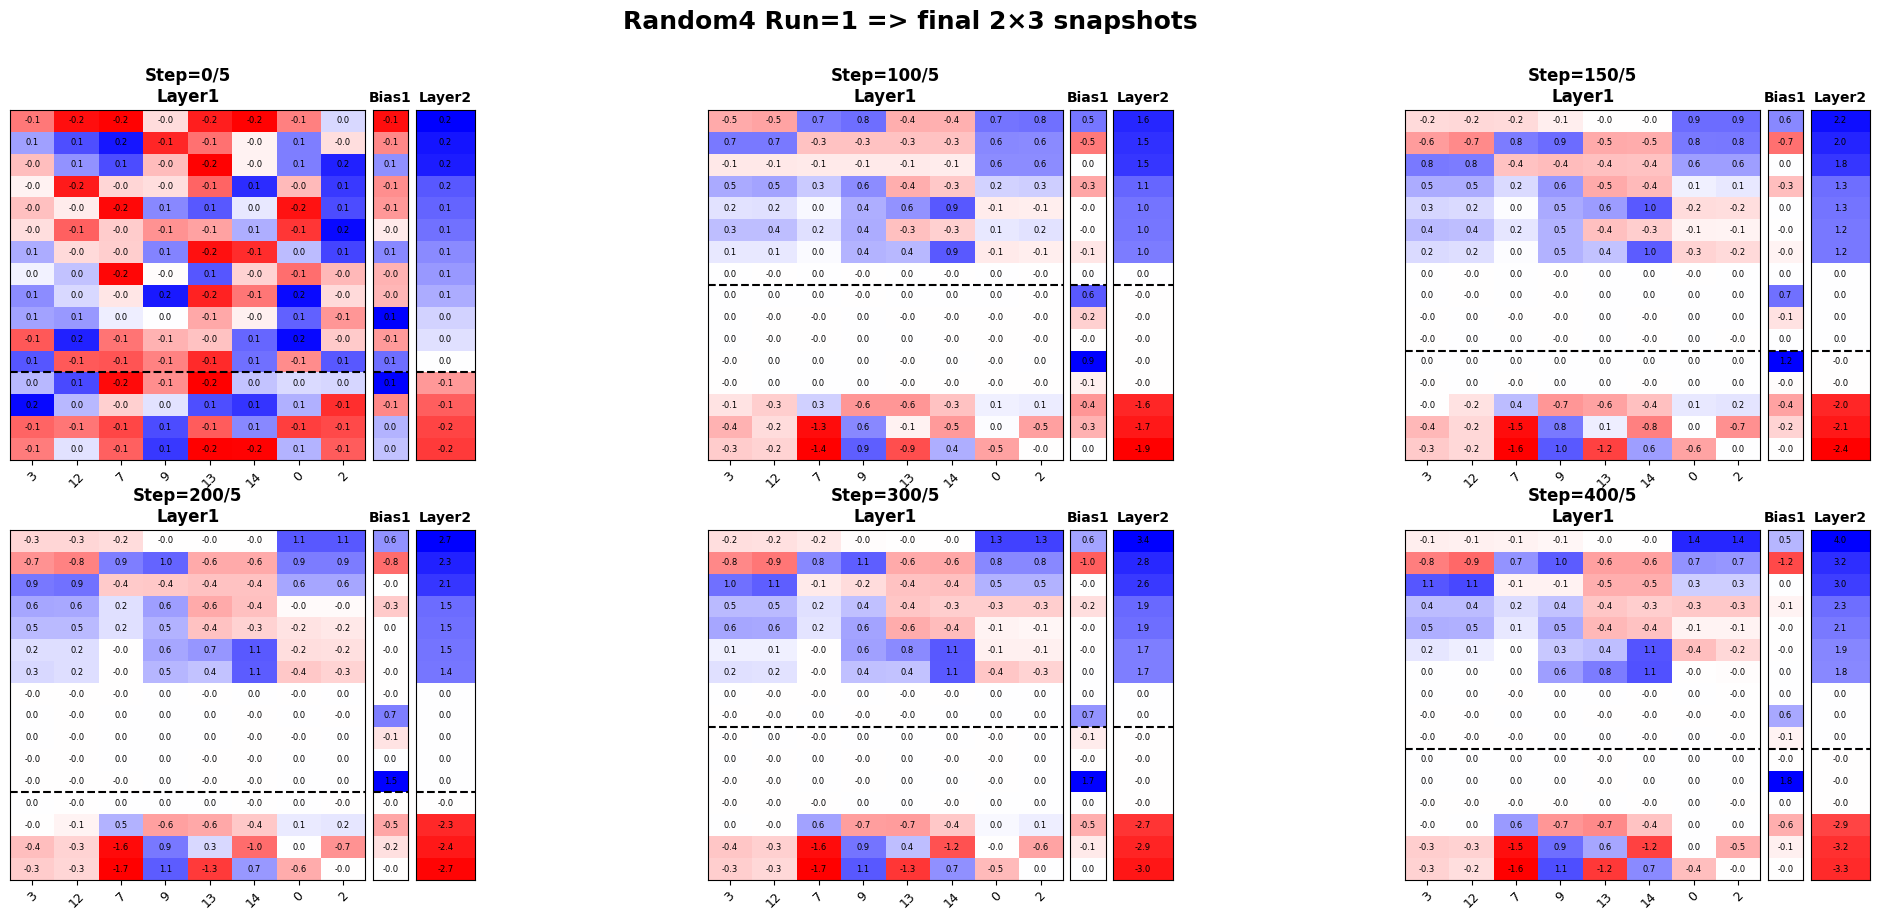

Saved => ./pdfs/Random4 Run=1_final_6snap_2x3.pdf


In [17]:
run = run_single_model(
    run_i= 0,
    num_features_per_clause=2,
    j_size=16,
    train_size=5000,
    test_size=1000,
    min_true_vars=2,
    max_true_vars=5,
    seed_offset=0,
    # base_dir=
    run_name= f"Run 4AND k=2",
    l2_reg_factor=0,
    l1_reg_factor=2e-3
)

In [ ]:
run = run_single_model(
    run_i= 0,
    num_features_per_clause=2,
    j_size=16,
    train_size=5000,
    test_size=1000,
    min_true_vars=2,
    max_true_vars=5,
    seed_offset=0,
    # base_dir=
    run_name= f"Run 4AND k=2",
    l2_reg_factor=0,
    l1_reg_factor=2e-3
)